# parse svg to get control points and length for each curve

In [131]:
from svg.path import parse_path
import xml.etree.ElementTree as ET
import numpy as np

ns = "{http://www.w3.org/2000/svg}"
tree = ET.parse("svgs/doll_dress.svg")
root = tree.getroot()

g = root.findall(ns + "g")[0]
paths = g.findall(ns  + "path")
path_objs = []

for p in paths:
    path_obj = parse_path(p.attrib["d"])
    path_objs.append(path_obj)


html_str_1 = '''
<!DOCTYPE html>
<html>
<body>

<svg height="800" width="1000">
<g transform="scale(4)">
'''

html_path_str = ""

# for p in paths:
#     html_path_str += "<path d=\"" + p.attrib["d"] + "\" />\n"
        
# [cps for curve1, cps for curve2, ...]
paths_cps = []
# [length of curve1, length of curve2, ...]
paths_lengths = []
# [[curve1_id, curve2_id, ..], [curve1_id, curve2_id, ..], ...] 
shape_curve_ids = []

c_id = 0
for p_obj in path_objs:
    path_cps = []
    path_lens = []
    curve_ids = []
    for i in range(len(p_obj)):
        curve = p_obj[i]
        p_name = type(curve).__name__
        d_str = ""
        if p_name == "CubicBezier":
            cpts = np.zeros([4, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.control1.real
            cpts[1][1] = -curve.control1.imag
            cpts[2][0] = curve.control2.real
            cpts[2][1] = -curve.control2.imag
            cpts[3][0] = curve.end.real
            cpts[3][1] = -curve.end.imag
            
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "C " + str(curve.control1.real) + " " + str(curve.control1.imag)
            d_str = d_str + ", " + str(curve.control2.real) + " " + str(curve.control2.imag)
            d_str = d_str + ", " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
        elif p_name == "Line" or p_name == "Close":
            if curve.length() < 0.0001:
                continue
                
            cpts = np.zeros([2, 2])
            cpts[0][0] = curve.start.real
            cpts[0][1] = -curve.start.imag
            cpts[1][0] = curve.end.real
            cpts[1][1] = -curve.end.imag
        
            d_str = d_str + "M " + str(curve.start.real) + " " + str(curve.start.imag) + " "
            d_str = d_str + "L " + str(curve.end.real) + " " + str(curve.end.imag)
            
            path_cps.append(cpts)
            curve_ids.append(c_id)
            
        else:
            continue
            
        path_lens.append(curve.length())
        
        html_path_str += "<path id = \"" + str(c_id) + "\" d=\"" + d_str + "\" stroke=\"black\" fill=\"transparent\" />\n"
        c_id +=1
        
    shape_curve_ids.append(curve_ids)
    paths_cps.extend(path_cps)
    paths_lengths.extend(path_lens)
        
# label the paths
html_text_str = "<text font-size=\"4\">"

for i in range(len(paths_cps)):
    html_text_str = html_text_str + "<textPath href=\"#" + str(i) + "\" startOffset=\"40%\">" + str(i) + "</textPath>\n"
html_text_str += "</text>"

# end of html file
html_str_2 = '''
</g>
</svg>

</body>
</html>
'''
html_file = open("svg_display.html", "w")
html_file.write(html_str_1)
html_file.write(html_path_str)
html_file.write(html_text_str)
html_file.write(html_str_2)
html_file.close()


In [132]:
shape_ccw = [None] * len(shape_curve_ids)
for sid in range(len(shape_curve_ids)):
    cids = shape_curve_ids[sid]
    v1 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num = 0
    
    def getAngle(v1, v2):
        cross_p = np.cross(v1, v2)
        cos_theta = np.dot(v1, v2);
        if cross_p > 0:
            return cos_theta
        else:
            return -cos_theta
            
    for cid in range(1, len(cids)):
        v2 = paths_cps[cids[cid]][-1] - paths_cps[cids[cid]][0]
        wind_num += getAngle(v1, v2)
        v1 = v2;

    v2 = paths_cps[cids[0]][-1] - paths_cps[cids[0]][0]
    wind_num += getAngle(v1, v2)
    
    if wind_num > 0:
        shape_ccw[sid] = True
    else:
        shape_ccw[sid] = False
print("shape_ccw: ", shape_ccw)

shape_ccw:  [False, False, False, True, True, True]


# specify pair of curves to match, if same orientation

In [133]:

# path_pairs_no_orientation = [
#     (8, 25), 
#     (22, 5), 
#     (13, 28),
#     (14, 19),
#     (30, 11),
#     (31, 2),
#     (23, 18),
#     (1, 6),
#     (27, 20),
#     (3, 10),
#     (12, 15),
#     (32, 29)
# ]

path_pairs_no_orientation = []
path_pairs = []

In [134]:
def getShapeId(cid):
    global shape_curve_ids
    for sid in range(len(shape_curve_ids)):
        if cid in shape_curve_ids[sid]:
            return sid

for ppair in path_pairs_no_orientation:
    sid1 = getShapeId(ppair[0])
    sid2 = getShapeId(ppair[1])
    ccw1 = shape_ccw[sid1]
    ccw2 = shape_ccw[sid2]  
    path_pairs.append((ppair[0], ppair[1], ccw1 != ccw2))

In [135]:
path_pairs

[]

In [136]:

import math

path_lens = np.array(path_lens)
# at least have this many pts on one curve
min_curve_pts_num = 6
# desired segment length
seg_len = np.amin(path_lens) / min_curve_pts_num

# get number of vertices for each curve
curve_vert_nums = [0] * len(paths_cps)

for pair in path_pairs:
    # use the maximum curve length of the pair of curves
    c1_len = paths_lengths[pair[0]]
    c2_len = paths_lengths[pair[1]]
    max_len = max(c1_len, c2_len)
    # ensure that each segment is less than seg_len
    c_vert_num = math.ceil( max_len / seg_len)
    # set vertices num for both curves
    curve_vert_nums[pair[0]] = c_vert_num
    curve_vert_nums[pair[1]] = c_vert_num

for cid in range(len(paths_cps)):
    # skip if already set
    if curve_vert_nums[cid] == 0:
        c_len = paths_lengths[cid]
        curve_vert_nums[cid] = math.ceil( c_len / seg_len)

bndry_verts = [None] * len(paths_cps) # all vertices!
bndry_reps = [None] * len(paths_cps)
err_thresh = 0.01
max_it = 20

def get_pair(c_id):
    global path_pairs
    for pair in path_pairs:
        if c_id == pair[0]:
            return pair[1]
        elif c_id == pair[1]:
            return pair[0]
    return -1

def getPtOnCurve(cps, t):
    return (1-t)**3 * cps[0] + 3*t*(1-t)**2 * cps[1] + 3*(1-t)*t**2 * cps[2] + t**3 * cps[3]

def getEquitDistantPtOnCurve(cps, pt_num, curve_len):
    N = 500
    prev_pt = cps[0]
    seg_lens = np.zeros(N)
    for i in range(1, N):
        t = i / N
        pt = getPtOnCurve(cps, t)
        seg_lens[i] = np.linalg.norm(pt - prev_pt)
        prev_pt = pt
    avg_seg_len = curve_len / pt_num
    bndry_pts = np.zeros([pt_num, 2])
    bndry_pts[0] = cps[0]

    last_seg = 0
    last_seg_part_len = 0
    ts = np.zeros(pt_num)

    for pt_id in range(1, pt_num):
        # find the segment up to which has avg_seg_len
        acc_len = last_seg_part_len
        for i in range(last_seg, N):
            if acc_len + seg_lens[i] < avg_seg_len:
                acc_len += seg_lens[i]
            else:
                # find the portion in segment
                last_seg_part_len = acc_len + seg_lens[i] - avg_seg_len
                last_seg = i + 1
                t = i / N - ( last_seg_part_len / seg_lens[i] ) / N
                ts[pt_id] = t
                bndry_pts[pt_id] = getPtOnCurve(cps, t)
#                 print("seg len = ", np.linalg.norm(bndry_pts[pt_id] - bndry_pts[pt_id-1]))
                break
    return bndry_pts, ts

def getTangent(cps, t):
    return 3 * (1-t)**2 * (cps[1] - cps[0]) + 6 * (1-t) * t * (cps[2] - cps[1]) + 3 * t**2 * (cps[3] - cps[2])

def getReps(cps, ts):
    reps = np.zeros([len(ts), 2])
    for i in range(len(ts)):
        tangent = getTangent(cps, ts[i])
        angle = np.arctan2(tangent[1], tangent[0])
        reps[i][0] = np.cos(angle * 4)
        reps[i][1] = np.sin(angle * 4)
    return reps

for curve_id in range(len(paths_cps)):
    curve_cps = paths_cps[curve_id]
    # number of verts on curve already calculated and stored in curve_vert_nums
    bndry_vert_num = curve_vert_nums[curve_id]
    
    # bezier curve
    if (len(curve_cps) == 4):
        curve_verts, ts = getEquitDistantPtOnCurve(curve_cps, bndry_vert_num, paths_lengths[curve_id])
        curve_reps = getReps(curve_cps, ts)
    # line
    elif (len(curve_cps) == 2):
        curve_verts = np.zeros([bndry_vert_num, 2])
        curve_reps = np.zeros([bndry_vert_num, 2])
        
        avg_seg_len = paths_lengths[curve_id] / bndry_vert_num
        d_t = 1 / bndry_vert_num
        t = 0
        dir_vec = (curve_cps[1] - curve_cps[0])
        angle = np.arctan2(dir_vec[1], dir_vec[0])
        rep = np.array([np.cos(angle * 4), np.sin(angle * 4)])
        for v_id in range(bndry_vert_num):
            pt_loc = curve_cps[0] + t * dir_vec
            curve_verts[v_id] = pt_loc
            curve_reps[v_id] = rep
            t += d_t
    
    bndry_verts[curve_id] = curve_verts
    bndry_reps[curve_id] = curve_reps

# resize the shape
size_multiplier = 1 / 16
for cid in range(len(bndry_verts)):
    for vid in range(len(bndry_verts[cid])):
        bndry_verts[cid][vid] *= size_multiplier

# how many vertices in each shape
shape_verts_num = [0] * len(path_objs)

for i in range(len(shape_curve_ids)):
    for curve_id in shape_curve_ids[i]:
        shape_verts_num[i] += len(bndry_verts[curve_id])


(9.402085573576628,
 11.772851929397508,
 -11.087286895567606,
 -5.670222534004477)

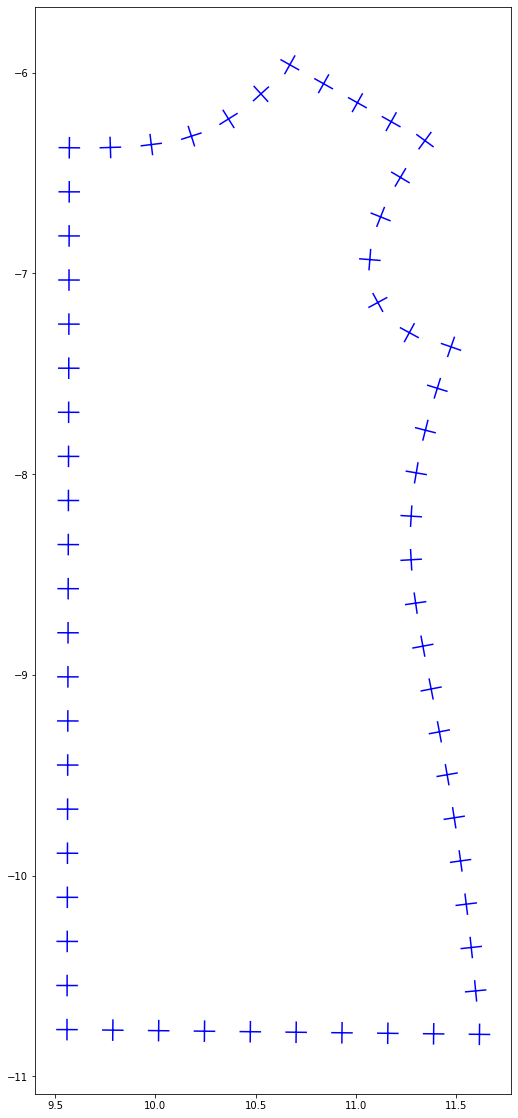

In [137]:
import matplotlib.pyplot as plt

cross_len = 0.05

plt.figure(figsize=(20,20))

shape1_verts = []
shape1_reps = []

def plotCross(plt, pt, rep, color='b'):
    rep_angle = np.arctan2(rep[1], rep[0])
    angle = rep_angle / 4
    
    for i in range(2):
#         plotVec(plt, pt, angle + i * np.pi / 2)
        v = np.array([np.cos(angle + i * np.pi / 2), np.sin(angle + i * np.pi / 2)])
        v *= cross_len
        v1 = v + pt
        v2 = -v + pt
        plt.plot([pt[0], v1[0]], [pt[1], v1[1]], '-', color=color)
        plt.plot([pt[0], v2[0]], [pt[1], v2[1]], '-', color=color)
        
def plotMemCross(plt, pt, angle, color='b'):
    for i in range(2):
        v = np.array([np.cos(angle + i * np.pi / 2), np.sin(angle + i * np.pi / 2)])
        v *= cross_len
        v1 = v + pt
        v2 = -v + pt
        plt.plot([pt[0], v1[0]], [pt[1], v1[1]], '-', color=color)
        plt.plot([pt[0], v2[0]], [pt[1], v2[1]], '-', color=color)

def plotVec(plt, pt, angle, length=cross_len, color='b'):
    v = np.array([np.cos(angle), np.sin(angle)])
    v *= cross_len
    v += pt
    plt.plot([pt[0], v[0]], [pt[1], v[1]], '-', color=color)
    
for cid in shape_curve_ids[0]:
    for i in range(len(bndry_verts[cid])):
        shape1_verts.append(bndry_verts[cid][i])
        shape1_reps.append(bndry_reps[cid][i])
        plotCross(plt, bndry_verts[cid][i], bndry_reps[cid][i])
        
plt.axis('scaled')
# plt.plot(bndry_verts[0][:,0], bndry_verts[0][:,1], 'o')

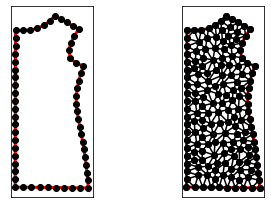

In [138]:
import matplotlib.pyplot as plt
import numpy as np

import triangle as tr

segments = []
for i in range(len(shape1_verts)-1):
    segments.append([i, i+1])
segments.append([len(shape1_verts)-1, 0])

A = dict(vertices=shape1_verts, segments=segments)
B = tr.triangulate(A, 'pqa.05')
# B = tr.triangulate(A, 'pqa.01')
tr.compare(plt, A, B)
plt.show()

In [139]:
faces = B['triangles']
vertices = B['vertices']
bndry_n = len(shape1_verts)
N = len(B['vertices'])

In [140]:
class HE:
    def __init__(self, vert, face, he_next=None, pair=None):
        self.vert = vert
        self.pair = pair
        self.face = face
        self.he_next = he_next
        
HEs = [None] * (len(faces) * 3)
HE_verts = [None] * len(vertices)
pairs = {}

def getPrevHeId(he_id):
    global HEs
    return HEs[HEs[he_id].he_next].he_next

for face_id in range (0, len(faces)):
    face = faces[face_id]
    face_HEs = []
    for i in range (0, 3):
        v_id = face[i]
        v_next_id = face[(i+1)%3]
        he = HE(v_next_id, face_id)
        face_HEs.append(he)
        HEs[int(3 * face_id + i)] = he
        pairs[(v_id, v_next_id)] = he
        HE_verts[v_next_id] = he
    for i in range(0, 3):
        face_HEs[i].he_next = face_HEs[(i+1)%3]
        
# find pairs
for he_id in range(len(HEs)):
    # get start, end vertex for he
    end_v = HEs[he_id].vert
    start_v = HEs[he_id].he_next.he_next.vert
    if (end_v, start_v) in pairs:
        HEs[he_id].pair = pairs[(end_v, start_v)]
        
    
def getNbs(v_id) :
    global HEs, HE_verts
    neighbors = []
    he = HE_verts[v_id]
    he = he.he_next
    first_he = he
    
    first_nb = he.vert
    neighbors.append(first_nb)
    
    if he.pair != None:
        he = he.pair.he_next
        on_bndry = False

        while he.vert != first_nb:
            neighbors.append(he.vert)
            if he.pair == None:
                on_bndry = True
                break
            he = he.pair.he_next
    else:
        on_bndry = True
        
    if on_bndry:
        other_side_nbs = []
        he =  first_he.he_next
        other_side_nbs.append(he.vert)
        he = he.he_next
        if he.pair != None:
            he = he.pair.he_next
            cnt = 0
            while he.vert != other_side_nbs[0]:
                other_side_nbs.append(he.vert)
                he = he.he_next
                if he.pair == None:
                    cnt = 100
                    break
                he = he.pair.he_next
                cnt += 1
        other_side_nbs.reverse()
        other_side_nbs.extend(neighbors)
        return other_side_nbs
    return neighbors


# get weight for half edge
def getHEWeight(he):
    global vertices, HEs
    vert_3 = np.array(vertices[he.he_next.vert])
    vert_1 = np.array(vertices[he.vert])
    vert_2 = np.array(vertices[he.he_next.he_next.vert])
    v1 = vert_1 - vert_3
    v2 = vert_2 - vert_3
#     print("v1, ", v1, ", v2, ", v2)
    cos_angle = np.dot(v1, v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))
    sign = np.cross(v1, v2)
#     print("sign: ", sign)
    # coordinate system has z axis going into the screen
    if sign > 0:
        cos_angle = -cos_angle
    sin_angle = math.sqrt(1 - cos_angle * cos_angle)
    return cos_angle / sin_angle


def getEdgeWeight(start_v, end_v):
    global pairs
    weight = 0
    if (start_v, end_v) in pairs:
        weight += getHEWeight(pairs[(start_v, end_v)])
    if (end_v, start_v) in pairs:
        weight += getHEWeight(pairs[(end_v, start_v)])
    return weight

        


In [141]:
M = np.zeros([N - bndry_n, N - bndry_n])
rhs_cos = np.zeros(N - bndry_n)
rhs_sin = np.zeros(N - bndry_n)

# build M
for v_idx in range (bndry_n, N):
    mtrx_idx = v_idx - bndry_n
    nbs = getNbs(v_idx)
    nb_weights = np.zeros(len(nbs))
    for nb_idx in range(len(nbs)):
        nb = nbs[nb_idx]
        nb_weights[nb_idx] = getEdgeWeight(v_idx, nb)
    nb_weights = nb_weights / np.sum(nb_weights)
    M[mtrx_idx][mtrx_idx] = 1
    
    for nb_idx in range(len(nbs)):
        nb = nbs[nb_idx]
        # on boundary
        if nb < bndry_n:
            rhs_cos[mtrx_idx] += shape1_reps[nb][0] * nb_weights[nb_idx]
            rhs_sin[mtrx_idx] += shape1_reps[nb][1] * nb_weights[nb_idx]
        else:
            M[mtrx_idx][nb - bndry_n] -= nb_weights[nb_idx]

In [142]:
Fs = np.linalg.solve(M, rhs_cos)
Gs = np.linalg.solve(M, rhs_sin)
FGs = np.stack((Fs, Gs)).T
rep_vs = np.concatenate((shape1_reps, FGs))
mem_as = [None]*len(rep_vs)

In [143]:
for i in range(len(rep_vs)):
    rep_angle = np.arctan2(rep_vs[i][1], rep_vs[i][0])
    angle = rep_angle / 4
    mem_as[i] = angle

In [159]:
class Singularity:
    def __init__(self, loc, vs, fgs, fid):
        self.loc = loc
        self.vs = vs
        self.bs = np.zeros(3)
        self.cs = np.zeros(3)
        
        self.bs[0] = vs[1][1] - vs[2][1]
        self.bs[1] = vs[2][1] - vs[0][1]
        self.bs[2] = vs[0][1] - vs[1][1]
        
        self.cs[0] = vs[2][0] - vs[1][0]
        self.cs[1] = vs[0][0] - vs[2][0]
        self.cs[2] = vs[1][0] - vs[0][0]
        
        self.twoA = np.dot(vs[:,0], self.bs)
        
        fs = fgs[:,0]
        gs = fgs[:,1]
        
        self.fid = fid
        
        self.fx = np.dot(fs, self.bs) / self.twoA
        self.fy = np.dot(fs, self.cs) / self.twoA
        self.gx = np.dot(gs, self.bs) / self.twoA
        self.gy = np.dot(gs, self.cs) / self.twoA
        
    def __repr__(self):
#         return "self.bs: " + str(self.bs) + ", self.cs: " + str(self.cs)
        return "fx: " + str(self.fx) + ", fy:" + str(self.fy) + ", gx:" + str(self.gx) + ", gy:" + str(self.gy)
        
    def fun(self, x):
#         return np.sin(4*x)/np.cos(4*x) - (self.gx*np.cos(x)+self.gy*np.sin(x))/(self.fx*np.cos(x)+self.fy*np.sin(x))
        return (4*np.sin(x)*np.cos(x)**3-4*np.sin(x)**3*np.cos(x)) / (np.sin(x)**4+np.cos(x)**4-6*np.sin(x)**2*np.cos(x)**2) - (self.gx*np.cos(x)+self.gy*np.sin(x))/(self.fx*np.cos(x)+self.fy*np.sin(x))

    def find_sep_angles(self):
        first_sol = opt.fsolve(self.fun, [0], xtol=1e-14)
        self.angles = [0] * 5
        
        i = 0
        while first_sol < 0:
            i += 1
            first_sol = opt.fsolve(self.fun, [i*np.pi/50], xtol=1e-12)
            
            
        offset = i*np.pi/50
        print("first_sol: ", first_sol)
        if first_sol > 0:
            guesses = np.linspace(0 + offset, np.pi + offset, num=20, endpoint=False)
            sols = opt.fsolve(self.fun, guesses, xtol=1e-12)
            prc_sols = np.sort(np.unique(sols.round(decimals=8)))
            
            print("prc_sols: ", prc_sols)
            
            prc_sols = prc_sols[:5]

        
#             for i in [1, 3]:
#                 prc_sols[i] -= np.pi
#         elif first_sol < 0:
#             guesses = np.linspace(-np.pi, 0, num=10, endpoint=False)
#             sols = opt.fsolve(self.fun, guesses, xtol=1e-14)
#             prc_sols = np.sort(np.unique(sols.round(decimals=8)))
#             prc_sols = prc_sols[len(prc_sols)-5:len(prc_sols)]
            
#             for i in [0, 2, 4]:
#                 prc_sols[i] += np.pi   
                
        self.angles = prc_sols
#         print("self.angles: ", self.angles)
#         for a in self.angles:
#             print("diff: ", self.fun(a))

        

In [164]:
import scipy.optimize as opt

singularities = []

for fid in range(len(faces)):
    face = faces[fid]
    vs = vertices[face]
    fgs = rep_vs[face]
    M = np.array([[fgs[0][0] - fgs[2][0], fgs[1][0] - fgs[2][0]], [fgs[0][1] - fgs[2][1], fgs[1][1] - fgs[2][1]]])
    if np.linalg.matrix_rank(M) < 2:
        continue
    rhs = np.array([-fgs[2][0], -fgs[2][1]])
    sing_coords = np.linalg.solve(M, rhs)
    if 0 <= sing_coords[0] <= 1 and 0 <= sing_coords[1] <= 1 and 0 <= sing_coords[0] + sing_coords[1] <= 1:
        sing_pos = sing_coords[0] * vs[0] + sing_coords[1] * vs[1] + (1 - sing_coords[0] - sing_coords[1]) * vs[2]
        sing = Singularity(sing_pos, vs, fgs, fid)
#         print("sing: ", sing)
        sing.find_sep_angles()
        singularities.append(sing)

# singularities[0].angles[0] = 2 * (-1.2996612093042432 + 3.141592653589793) + np.pi
# singularities[0].angles[1] = 2 * (-1.0111408836654397 + 3.141592653589793)
# singularities[0].angles[2] = 2 * (-0.7313241540730885 + 3.141592653589793) + np.pi
# singularities[0].angles[3] = 2 * (-0.4061461121898705 + 3.141592653589793)
# singularities[0].angles[4] = 2 * (-0.06130448141802000 + 3.141592653589793) + np.pi

# singularities[1].angles[0] = 2 * (-1.5432324894403669 + 3.141592653589793) + np.pi
# singularities[1].angles[1] = 2 * (-1.1907274090096668 + 3.141592653589793)
# singularities[1].angles[2] = 2 * (-0.8360521885797059 + 3.141592653589793) + np.pi
# singularities[1].angles[3] = 2 * (-0.5223831721808096 + 3.141592653589793)
# singularities[1].angles[4] = 2 * (-0.2760021319389816 + 3.141592653589793) + np.pi

singularities[0].angles[0] = 2 * (-1.4401208674010802  + 3.141592653589793)
singularities[0].angles[1] = 2 * (-1.2173278794409563  + 3.141592653589793) + np.pi
singularities[0].angles[2] = 2 * (-0.9387625018349566  + 3.141592653589793)
singularities[0].angles[3] = 2 * (-0.5781120618145848  + 3.141592653589793) + np.pi
singularities[0].angles[4] = 2 * (-0.2089371034607838  + 3.141592653589793)

singularities[1].angles[0] = 2 * (-1.4171257498968749  + 3.141592653589793)
singularities[1].angles[1] = 2 * (-1.1091057988508399  + 3.141592653589793) + np.pi
singularities[1].angles[2] = 2 * (-0.8077737268427351  + 3.141592653589793)
singularities[1].angles[3] = 2 * (-0.4940581823882593  + 3.141592653589793) + np.pi
singularities[1].angles[4] = 2 * (-0.1687911723476792  + 3.141592653589793)

for a in singularities[0].angles:
    print("diff: ", singularities[0].fun(a))
print("singularities[0].angles: ", singularities[0].angles)

for a in singularities[1].angles:
    print("diff: ", singularities[1].fun(a))
print("singularities[1].angles: ", singularities[0].angles)


first_sol:  [0.26135092]
prc_sols:  [  0.26135092   0.70693689   1.26406765   2.72371845   3.40294357
   3.84852955   4.4056603   23.25521623 261.01354117]
first_sol:  [0.30734115]
prc_sols:  [0.30734115 0.92338106 1.5260452  2.15347629 2.80401031]
diff:  -5.551115123125783e-15
diff:  -6.439293542825908e-15
diff:  7.993605777301127e-15
diff:  5.684341886080802e-14
diff:  5.5067062021407764e-14
singularities[0].angles:  [3.40294357 6.9901222  4.4056603  8.26855384 5.8653111 ]
diff:  -2.1316282072803006e-14
diff:  -5.88418203051333e-15
diff:  6.938893903907228e-16
diff:  -1.5987211554602254e-14
diff:  -4.707345624410664e-14
singularities[1].angles:  [3.40294357 6.9901222  4.4056603  8.26855384 5.8653111 ]


In [165]:

dt_reg = 0.01
dt_init = 0.01

def getBaryCoords(v, vs):
    M = np.zeros([2,2])
    M[0] = vs[0] - vs[2]
    M[1] = vs[1] - vs[2]
    rhs = v - vs[2]
    bary_coords = np.linalg.solve(M.T, rhs)
    bary_coords = np.append(bary_coords, 1-bary_coords[0]-bary_coords[1])
    return bary_coords
        
def inRange(coords):
    res = True
    for i in range(3):
        res = res and (coords[i] >= 0 and coords[i] <=1)
    return res

def findFace(v):
    global faces, vertices
    
    for fid in range(len(faces)):
        vs = vertices[faces[fid]]
        bary_coords = getBaryCoords(v, vs)
        
        if inRange(bary_coords):
            return (fid, bary_coords)
    return None

stream_lines = []

def getClosestArm(rep, v_angle):
    rep_angle = np.arctan2(rep[1], rep[0])
    start_angle = rep_angle / 4
#     v_angle = np.arctan2(v[1], v[0])
    v_angle = ( v_angle + 2 * np.pi ) % ( 2 * np.pi )
    min_diff = np.inf
    min_arm_angle = 0
    
    for i in range(4):
        arm_angle = ( start_angle + i * np.pi / 2 + 2 * np.pi ) % ( 2 * np.pi )
        diff = min( abs(arm_angle - v_angle), 2 * np.pi - abs(arm_angle - v_angle) )
        if diff < min_diff:
            min_diff = diff
            min_arm_angle = arm_angle
            
    return min_arm_angle

def traceSeparatrix(src_sing, angle_id):
    global dt_reg, dt_init, stream_lines
    
    stream_line = []
    stream_line.append(src_sing.loc)

    v = src_sing.loc + dt_init * np.array([np.cos(src_sing.angles[angle_id]), np.sin(src_sing.angles[angle_id])])
    res = findFace(v)
    fid = res[0]
    coords = res[1]
    stream_dir = np.array([np.cos(src_sing.angles[angle_id]), np.sin(src_sing.angles[angle_id])])
    arm_angle = src_sing.angles[angle_id]
    
    dt = dt_init
    while True:
        met_sing = False
        for sing in singularities:
            if sing == src_sing:
                continue
            if fid == sing.fid:
                stream_line.append(v)
                stream_line.append(sing.loc)
                met_sing = True
                break
        if met_sing:
            break
        
                
        face = faces[fid]
        stream_line.append(v)

        fgs = np.array(rep_vs[face])
        fg = coords[0] * fgs[0] + coords[1] * fgs[1] + coords[2] * fgs[2]
        fg_norm = np.linalg.norm(fg)
            
        arm_angle = getClosestArm(fg, arm_angle)
        arm_v = np.array([np.cos(arm_angle), np.sin(arm_angle)]) * fg_norm

        v = v + dt * arm_v
        
        test_coords = getBaryCoords(v, vertices[face])
        if inRange(test_coords):
            coords = test_coords
            continue
        else:
            dt = dt_reg
            res = findFace(v)
            if res == None:
                break
            fid = res[0]
            coords = res[1]

    stream_line = np.array(stream_line)
    stream_lines.append(stream_line)

for sing in singularities:
# sing = singularities[0]
    for a_id in range(len(sing.angles)):
        traceSeparatrix(sing, a_id)

(9.402085573576628,
 11.772851929397508,
 -11.087286895567606,
 -5.670222534004477)

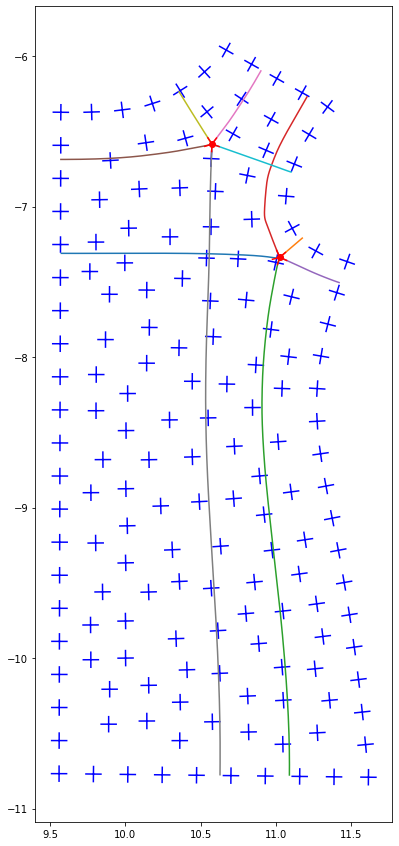

In [168]:
plt.figure(figsize=(15, 15))
    
for vid in range(N):
    plotMemCross(plt, vertices[vid], mem_as[vid])

for stream_line in stream_lines:
    plt.plot(stream_line[:,0], stream_line[:,1])
    
for sing in singularities:
    plt.plot(sing.loc[0], sing.loc[1], 'o', color='r')
    for i in range(5):
        plotVec(plt, sing.loc, sing.angles[i], length=0.5, color='r')
plt.axis('scaled')

#     tr.plot(plt.axes(), **B)

(9.48259089810458, 11.51252564807607, -7.566636478596739, -6.2047618709571095)

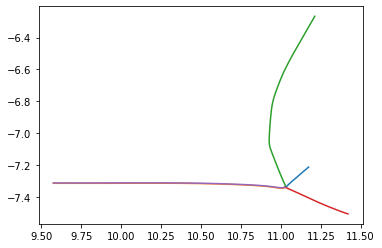

In [149]:
for stream_line in stream_lines[:5]:
    plt.plot(stream_line[:,0], stream_line[:,1])
plt.axis('scaled')

(3.0618534447497714,
 6.463292920776693,
 -10.226426696156766,
 -10.192950276342042)

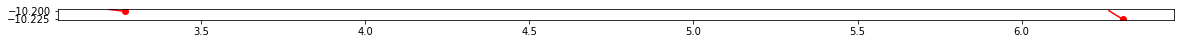

In [25]:
plt.figure(figsize=(20,20))
for sing in singularities:
    plt.plot(sing.loc[0], sing.loc[1], 'o', color='r')
    for i in range(4,5):
        plotVec(plt, sing.loc, sing.angles[i]+np.pi, length=0.5, color='r')
plt.axis('scaled')